## NOTES:
- The following are experimental plots for data visualization and exploration

## Imports

In [1]:
#Python3.10
import numpy as np
import pandas as pd 
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.graph_objects as go
from importlib import reload
import mapclassify as mc
import contextily as cx

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Custom modules are imported in multiple locations to faciliate easy reloading when edits are made to their respective files
import Src.classes as cl
import Src.func as fn
reload(cl)
reload(fn)

<module 'Src.func' from 'c:\\Users\\alekh\\OneDrive - University of California, Davis\\WORK\\DahlkeLab_LAWR\\Src\\func.py'>

Global Shapefiles:

In [2]:
# Takes about 30s to import these four files, but then they can be used everywhere in this notebook
huc2_shape = gpd.read_file('ShapeFiles/HUC2/_Master_HUC2/master_huc2.shp')
huc4_shape = gpd.read_file('ShapeFiles/HUC4/_Master_HUC4/master_huc4.shp')
aq_shape = gpd.read_file('ShapeFiles/Aquifers/_Master_Aquifer/master_aquifer.shp')
stream_network = gpd.read_file('ShapeFiles/Lower48/stream_network.shp')

## Plot 1: Single Aquifer Metrics by HUC4 Plot
Visualizing the single highest {metric} per HUC4 for a given aquifer

In [285]:
aquifer = cl.high_plains_aquifer
date_range = 30
quantile = 90
metric = 'annual_hmf'
dataset = f'Prelim_Data/{aquifer.name}/{aquifer.name}_{date_range}_{quantile}.xlsx'

try:
    df_1 = pd.read_excel(dataset, dtype=fn.DATASET_DTYPES)
    df_1, _ = fn.filter_by_valid(df_1)
    df_1 = df_1.reset_index(drop=True)
except Exception as e:
    print(e)
    df_1 = pd.DataFrame()    

['06438000', '06452000', '06465500', '06485500', '06630000', '06730500', '06805500', '06793000', '06800500', '06857100', '06877600', '06892350', '07109500', '07146500', '07154500', '07160000', '07152500', '07221500', '07245000', '07243500', '07305000', '07316000', '08080500', '08123850', '08384500', '08412500']


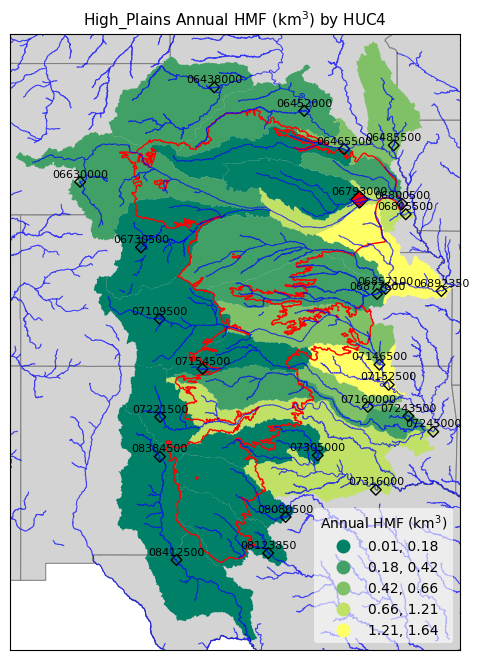

In [286]:
fig, ax = plt.subplots(figsize=(8, 8))
title = plt.title(f"{aquifer.name} {fn.FLOW_METRIC_UNITS[metric]} by HUC4", x=0.5, y=1.0, fontsize=11)
title.set_bbox({'facecolor': 'none', 'alpha': 0.75, 'edgecolor': 'none'})

legend_frmt = {
    "title": f"{fn.FLOW_METRIC_UNITS[metric]}",
    "loc": "lower right",
    "reverse": False,
    "facecolor": "white",
    "alignment": 'center',
    "edgecolor": 'none',
    "framealpha": 0.60
}

# Background plots
fn.plot_lower_48(ax, facecolor='lightgray', edgecolor='gray')
fn.plot_stream_network(stream_network, ax, zorder=2, alpha=0.70)

huc4_shape_1 = huc4_shape[huc4_shape['huc4_code'].isin(aquifer.huc4s)]
if not df_1.empty:
    huc_max = df_1.groupby('huc4_code')[metric].idxmax()
    df_1 = df_1.loc[huc_max]
    gdf_1 = huc4_shape_1.merge(df_1, on='huc4_code')
    gdf_1.plot(ax=ax, column=metric, scheme="naturalbreaks", cmap='summer', legend=True, legend_kwds=legend_frmt, alpha=1.0, edgecolor='none', linewidth=0.35)
    
aq_shape_1 = aq_shape[aq_shape['aq_name'] == aquifer.name]
aq_shape_1.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=1.0, alpha=1.0)

offset = 0.12
site_list = []
if not df_1.empty:
    # Can use index if site_no's overlap each other due to proximity of points
    for i, site_no in enumerate(gdf_1['site_no']):
        plt.annotate(site_no, (gdf_1['dec_long_va'].iloc[i], gdf_1['dec_lat_va'].iloc[i] + offset), fontsize=8, alpha=1.0, color='black', ha='center')
        site_list.append(str(site_no))
        
    plt.scatter(gdf_1['dec_long_va'], gdf_1['dec_lat_va'], color='none', edgecolor='black', marker='D', s=30, alpha=1.0)
    gdf_1 = gdf_1[gdf_1['within_aq'] == aquifer.name]
    max = gdf_1[metric].idxmax()
    gdf_1 = gdf_1.loc[max]
    plt.scatter(gdf_1['dec_long_va'], gdf_1['dec_lat_va'], color='red', edgecolor='black', marker='D', s=75, alpha=1.0)  
    
print(site_list)
xmin, xmax, ymin, ymax = fn.set_plot_bounds(huc4_shape_1, padding=0.20)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_yticks([])
ax.set_xticks([])
plt.show()


## Plot 1.5: Single Aquifer Metrics (in bounds only)
This creates the same plot as above, but first restricts the HUC4s and their gauges to only those within the aquifer boundary. Useful for determining if there are other useable outlet gauges in a HUC4 whose outlet gauge might otherwise be outside the aquifer boundary

['06449500', '06461500', '06674500', '06796000', '06793000', '06799000', '06853500', '06880800', '07144200', '07157500', '07228000', '07235000']


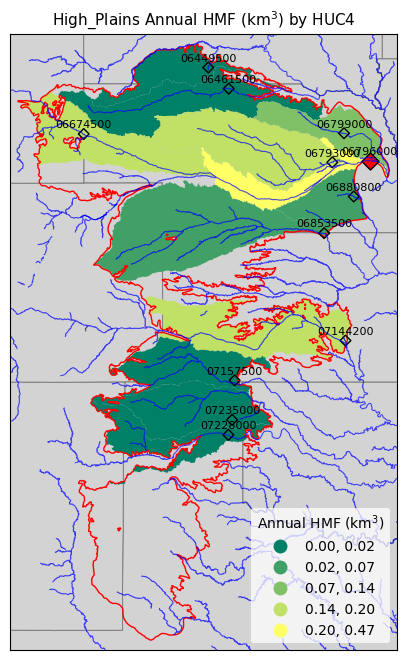

In [280]:
aquifer = cl.high_plains_aquifer
date_range = 30
quantile = 90
metric = 'annual_hmf'
dataset = f'Prelim_Data/{aquifer.name}/{aquifer.name}_{date_range}_{quantile}.xlsx'

try:
    df_1 = pd.read_excel(dataset, dtype=fn.DATASET_DTYPES)
    df_1, _ = fn.filter_by_valid(df_1)
    df_1 = df_1.reset_index(drop=True)
except Exception as e:
    print(e)
    df_1 = pd.DataFrame()  
    
fig, ax = plt.subplots(figsize=(8, 8))
title = plt.title(f"{aquifer.name} {fn.FLOW_METRIC_UNITS[metric]} by HUC4", x=0.5, y=1.0, fontsize=11)
title.set_bbox({'facecolor': 'none', 'alpha': 0.75, 'edgecolor': 'none'})

legend_frmt = {
    "title": f"{fn.FLOW_METRIC_UNITS[metric]}",
    "loc": "lower right",
    "reverse": False,
    "facecolor": "white",
    "alignment": 'center',
    "edgecolor": 'none',
    "framealpha": 0.75
}

# Background plots
fn.plot_lower_48(ax, facecolor='lightgray', edgecolor='gray')
fn.plot_stream_network(stream_network, ax, zorder=2, alpha=0.70)

huc4_shape_1 = huc4_shape[huc4_shape['huc4_code'].isin(aquifer.huc4s)]
aq_shape_1 = aq_shape[aq_shape['aq_name'] == aquifer.name]
intersect = gpd.overlay(aq_shape_1, huc4_shape_1, how='intersection')

if not df_1.empty:
    df_1 = df_1[df_1['within_aq'] == aquifer.name].reset_index(drop=True)
    huc_max = df_1.groupby('huc4_code')[metric].idxmax()
    df_1 = df_1.loc[huc_max]
    gdf_1 = intersect.merge(df_1, on='huc4_code')
    gdf_1.plot(ax=ax, column=metric, scheme="naturalbreaks", cmap='summer', legend=True, legend_kwds=legend_frmt, alpha=1.0, edgecolor='none', linewidth=0.35)
    
aq_shape_1 = aq_shape[aq_shape['aq_name'] == aquifer.name]
aq_shape_1.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=1.0, alpha=1.0)

offset = 0.12
site_list = []
if not df_1.empty:
    # Can use index if site_no's overlap each other due to proximity of points
    for i, site_no in enumerate(gdf_1['site_no']):
        plt.annotate(site_no, (gdf_1['dec_long_va'].iloc[i], gdf_1['dec_lat_va'].iloc[i] + offset), fontsize=8, alpha=1.0, color='black', ha='center')
        site_list.append(str(site_no))
        
    plt.scatter(gdf_1['dec_long_va'], gdf_1['dec_lat_va'], color='none', edgecolor='black', marker='D', s=30, alpha=1.0)
    gdf_1 = gdf_1[gdf_1['within_aq'] == aquifer.name]
    max = gdf_1[metric].idxmax()
    gdf_1 = gdf_1.loc[max]
    plt.scatter(gdf_1['dec_long_va'], gdf_1['dec_lat_va'], color='red', edgecolor='black', marker='D', s=75, alpha=1.0)  
    
print(site_list)
xmin, xmax, ymin, ymax = fn.set_plot_bounds(aq_shape_1, padding=0.20)
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_yticks([])
ax.set_xticks([])
plt.show()

## Plot 2: All Aquifer 3-Month, 6-Month, Annual HMF

In [4]:
aquifers = cl.ALL_AQUIFERS
date_range = 30
quantile = 90
dataset = f'Prelim_Data/_National_Metrics/National_Metrics_{date_range}_{quantile}.xlsx'

try:
    df_2 = pd.read_excel(dataset, dtype=fn.DATASET_DTYPES)
    df_2, _ = fn.filter_by_valid(df_2)
    df_2 = df_2.reset_index(drop=True)
except Exception as e:
    print(e)
    df_2 = pd.DataFrame()  

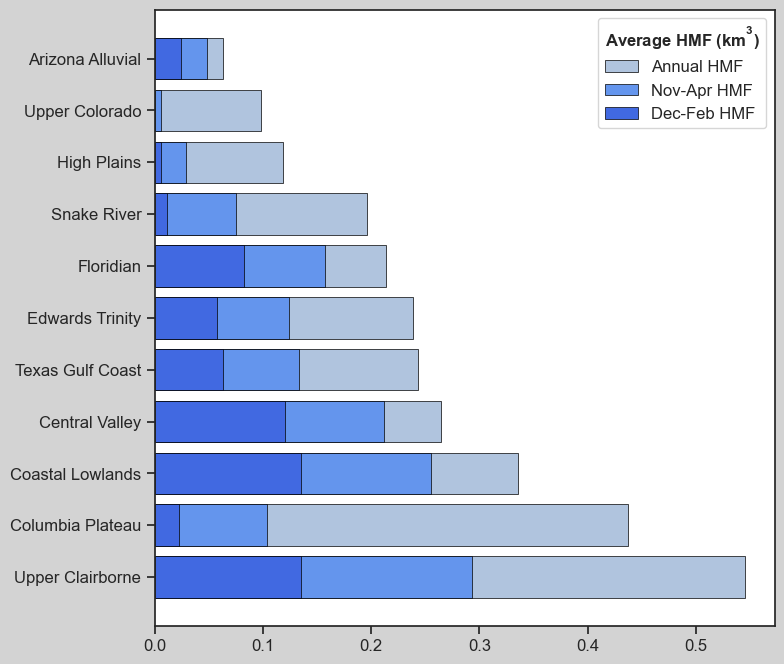

In [5]:
# Data init
df_to_plot = pd.DataFrame()
for aq in cl.ALL_AQUIFERS:
    df_temp = df_2[df_2['huc4_code'].isin(aq.huc4s)]
    
    data = {
        'aq_name': aq.name.replace('_', ' '),
        'annual_hmf': df_temp['annual_hmf'].mean(),
        'six_mo_hmf': df_temp['six_mo_hmf'].mean(),
        'three_mo_hmf': df_temp['three_mo_hmf'].mean(),
    }
    
    df_to_plot = pd.concat([df_to_plot, pd.DataFrame(data, index=[0])])
df_to_plot = df_to_plot.sort_values('annual_hmf', ascending=False)

# Plotting
fig, ax = plt.subplots(figsize=(8, 8), facecolor='lightgray')
plt.barh(df_to_plot['aq_name'], df_to_plot['annual_hmf'], color='lightsteelblue', label="Annual HMF" ,edgecolor='black', linewidth=0.5)
plt.barh(df_to_plot['aq_name'], df_to_plot['six_mo_hmf'],color='cornflowerblue', label="Nov-Apr HMF", edgecolor='black', linewidth=0.5)
plt.barh(df_to_plot['aq_name'], df_to_plot['three_mo_hmf'], color='royalblue', label="Dec-Feb HMF", edgecolor='black', linewidth=0.5)

legend = plt.legend(alignment='left', fontsize=12)
legend.set_title('Average HMF ($\mathregular{km^3}$)', {'weight': 'bold', 'size': 12})
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
#ax.spines['left'].set_visible(False)
#ax.set_facecolor('lightgray')
plt.show()

The same plot but circular -- Not a fan...

In [ ]:
num_angles = len(aquifers)
angles = np.linspace(0, 2 * np.pi, num_angles, endpoint=False).tolist()
rad_pos = np.linspace(0, df_to_plot['annual_hmf'].max() * 1.2, 5)

fix, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'}, facecolor='lightgray')
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

ax.bar(angles, df_to_plot['annual_hmf'], width=0.35, color='lightsteelblue', label="Annual HMF", edgecolor='black', linewidth=0.5, alpha=1.0)
ax.bar(angles, df_to_plot['six_mo_hmf'], width=0.35, color='cornflowerblue', label="Nov-Apr HMF", edgecolor='black', linewidth=0.5, alpha=1.0)
ax.bar(angles, df_to_plot['three_mo_hmf'], width=0.35, color='royalblue', label="Dec-Feb HMF", linewidth=0.5, alpha=1.0)

ax.set_xticks(np.linspace(0, 2 * np.pi, num_angles, endpoint=False))
ax.set_xticklabels([name for name in df_to_plot['aq_name']], fontsize=12)
ax.grid(False, axis='x')
ax.set_frame_on(False)

legend = plt.legend(alignment='left', fontsize=12, loc='upper left')
legend.set_title('Average HMF ($\mathregular{km^3}$)', {'weight': 'bold', 'size': 12})
legend.set_bbox_to_anchor((-0.25, 1.0, 0.1, 0.1))
plt.show()

## Plot 3: All Aquifer Metrics Violin Plots
Visualization of the 12 aquifers relative metrics

In [12]:
aquifers = cl.ALL_AQUIFERS
date_range = 30
quantile = 90
metric = 'inter_annual%'

dataset = f'Prelim_Data/_National_Metrics/National_Metrics_{date_range}_{quantile}.xlsx'
try:
    df_3 = pd.read_excel(dataset, dtype=fn.DATASET_DTYPES)
    df_3, _ = fn.filter_by_valid(df_3)
    df_3 = df_3.reset_index(drop=True)
except Exception as e:
    print(e)
    df_3 = pd.DataFrame() 

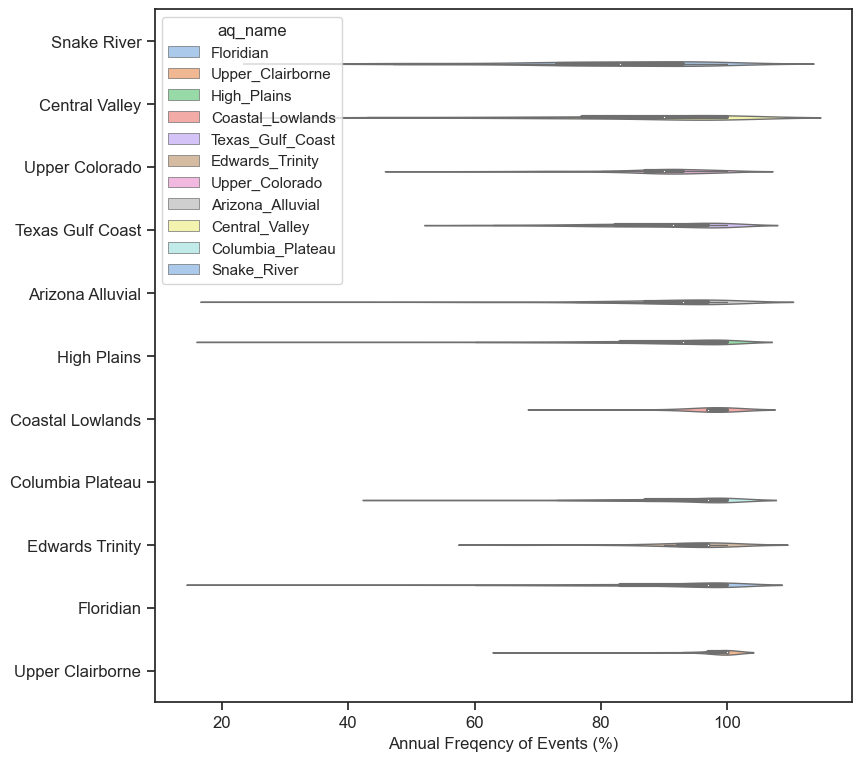

In [14]:
# Data init
# NOTE: Right now this uses a lazy method of assigning aquifers to sites, in which some sites are overwritten
# if they're part of more than one aquifer. Not an issue for general trend visualization, but should be corrected
# before this plot is used for anything more serious.
for i, row in df_3.iterrows():
    for aquifer in aquifers:
        if row['huc4_code'] in aquifer.huc4s:
            df_3.at[i, 'aq_name'] = aquifer.name            
            
df_to_plot = df_3[['aq_name', metric]].dropna()
order = df_to_plot.groupby('aq_name').median().sort_values(metric, ascending=True).index

sns.set_theme(style="ticks")
fig, ax = plt.subplots(figsize=(9, 9))
sns.violinplot(x=metric, y='aq_name', hue='aq_name', data=df_to_plot, order=order, density_norm='width', linewidth=1.0, orient='h', palette='pastel', legend=False)

yticks = [tick.get_text().replace('_', ' ') for tick in ax.get_yticklabels()]
ytick_pos = ax.get_yticks()
plt.xticks(fontsize=12)
plt.yticks(ytick_pos, yticks, fontsize=12)
# Tick marks for DOHY specifically
#plt.yticks([0, 61, 123, 183, 244, 305], ['Oct', 'Dec', 'Feb', 'Apr', 'Jun', 'Aug'], fontsize=12)
plt.xlabel(fn.FLOW_METRIC_UNITS[metric], fontsize=12)
plt.ylabel(None)
plt.show()


## Plot 4 & Analysis: Highest HMF Outlet Gauge within Aquifer Bounds

Reports in a spreadsheet and plots the highest HMF water guage within each aquifer's bounds

In [14]:
aquifers = cl.ALL_AQUIFERS
date_range = 30
quantile = 90
metric = 'annual_hmf'
test_limit = 99

In [23]:
# This section populates the df_outlets dataframe which is used for the following sections plot
df_outlets = pd.DataFrame()
for i, aquifer in enumerate(aquifers):
    if i >= test_limit: break
    dataset = f'{aquifer.datasets_dir}/{aquifer.name}_{date_range}_{quantile}.xlsx'
    
    # Data init
    try:
        df_4 = pd.read_excel(dataset, dtype=fn.DATASET_DTYPES)
        #df_4, _ = fn.filter_by_valid(df_4)
        #df_4 = df_4.reset_index(drop=True)
    except Exception as e:
        print(e)
        df_4 = pd.DataFrame() 
        break
    
    # Find max metric values and ratio of complete aquifer max to bounded max
    aquifer_max = df_4[metric].max()
    df_aq_bounds = df_4[df_4['within_aq'] == aquifer.name]
    bounded_max = df_aq_bounds[metric].max()
    max_ratio = round(bounded_max / aquifer_max, 2) * 100    
    
    data = df_aq_bounds.loc[df_aq_bounds[metric].idxmax()].to_frame().T.reset_index(drop=True)
    add_data = {f'{metric}_max': aquifer_max, f'{metric}_bounded_max': bounded_max, 'max_ratio': max_ratio}
    data = pd.concat([data.reset_index(), pd.DataFrame(add_data, index=[0])], axis=1)
    df_outlets = pd.concat([df_outlets.reset_index(drop=True), data.reset_index(drop=True)]).reset_index(drop=True)
    df_outlets = df_outlets.drop(columns='index')  
    
    print(f'Aquifer: {aquifer.name}')
    print(f'Site: {data["site_no"].to_string(index=False)} | Aq_Max: {aquifer_max:.3f} | Bnd_Max: {bounded_max:.3f} | Ratio: {max_ratio:.0f}%')

    
#df_outlets.to_excel(f'Prelim_Data/{metric}_outlet_gauges.xlsx')

Aquifer: Arizona_Alluvial
Site: 09519800 | Aq_Max: 1.063 | Bnd_Max: 1.063 | Ratio: 100%
Aquifer: Central_Valley
Site: 11453000 | Aq_Max: 3.008 | Bnd_Max: 3.008 | Ratio: 100%
Aquifer: Coastal_Lowlands
Site: 02479000 | Aq_Max: 3.462 | Bnd_Max: 1.471 | Ratio: 42%
Aquifer: Columbia_Plateau
Site: 14105700 | Aq_Max: 8.263 | Bnd_Max: 8.263 | Ratio: 100%
Aquifer: Edwards_Trinity
Site: 07331600 | Aq_Max: 2.212 | Bnd_Max: 2.052 | Ratio: 93%
Aquifer: Floridian
Site: 02226000 | Aq_Max: 2.514 | Bnd_Max: 1.890 | Ratio: 75%
Aquifer: High_Plains
Site: 06796000 | Aq_Max: 1.636 | Bnd_Max: 0.472 | Ratio: 29%
Aquifer: Pennsylvanian
Site: 03086000 | Aq_Max: 7.720 | Bnd_Max: 2.335 | Ratio: 30%
Aquifer: Snake_River
Site: 13269000 | Aq_Max: 2.002 | Bnd_Max: 2.002 | Ratio: 100%
Aquifer: Texas_Gulf_Coast
Site: 08116650 | Aq_Max: 2.212 | Bnd_Max: 2.184 | Ratio: 99%
Aquifer: Upper_Clairborne
Site: 07032000 | Aq_Max: 17.784 | Bnd_Max: 17.784 | Ratio: 100%
Aquifer: Upper_Colorado
Site: 09180500 | Aq_Max: 0.977 | Bn

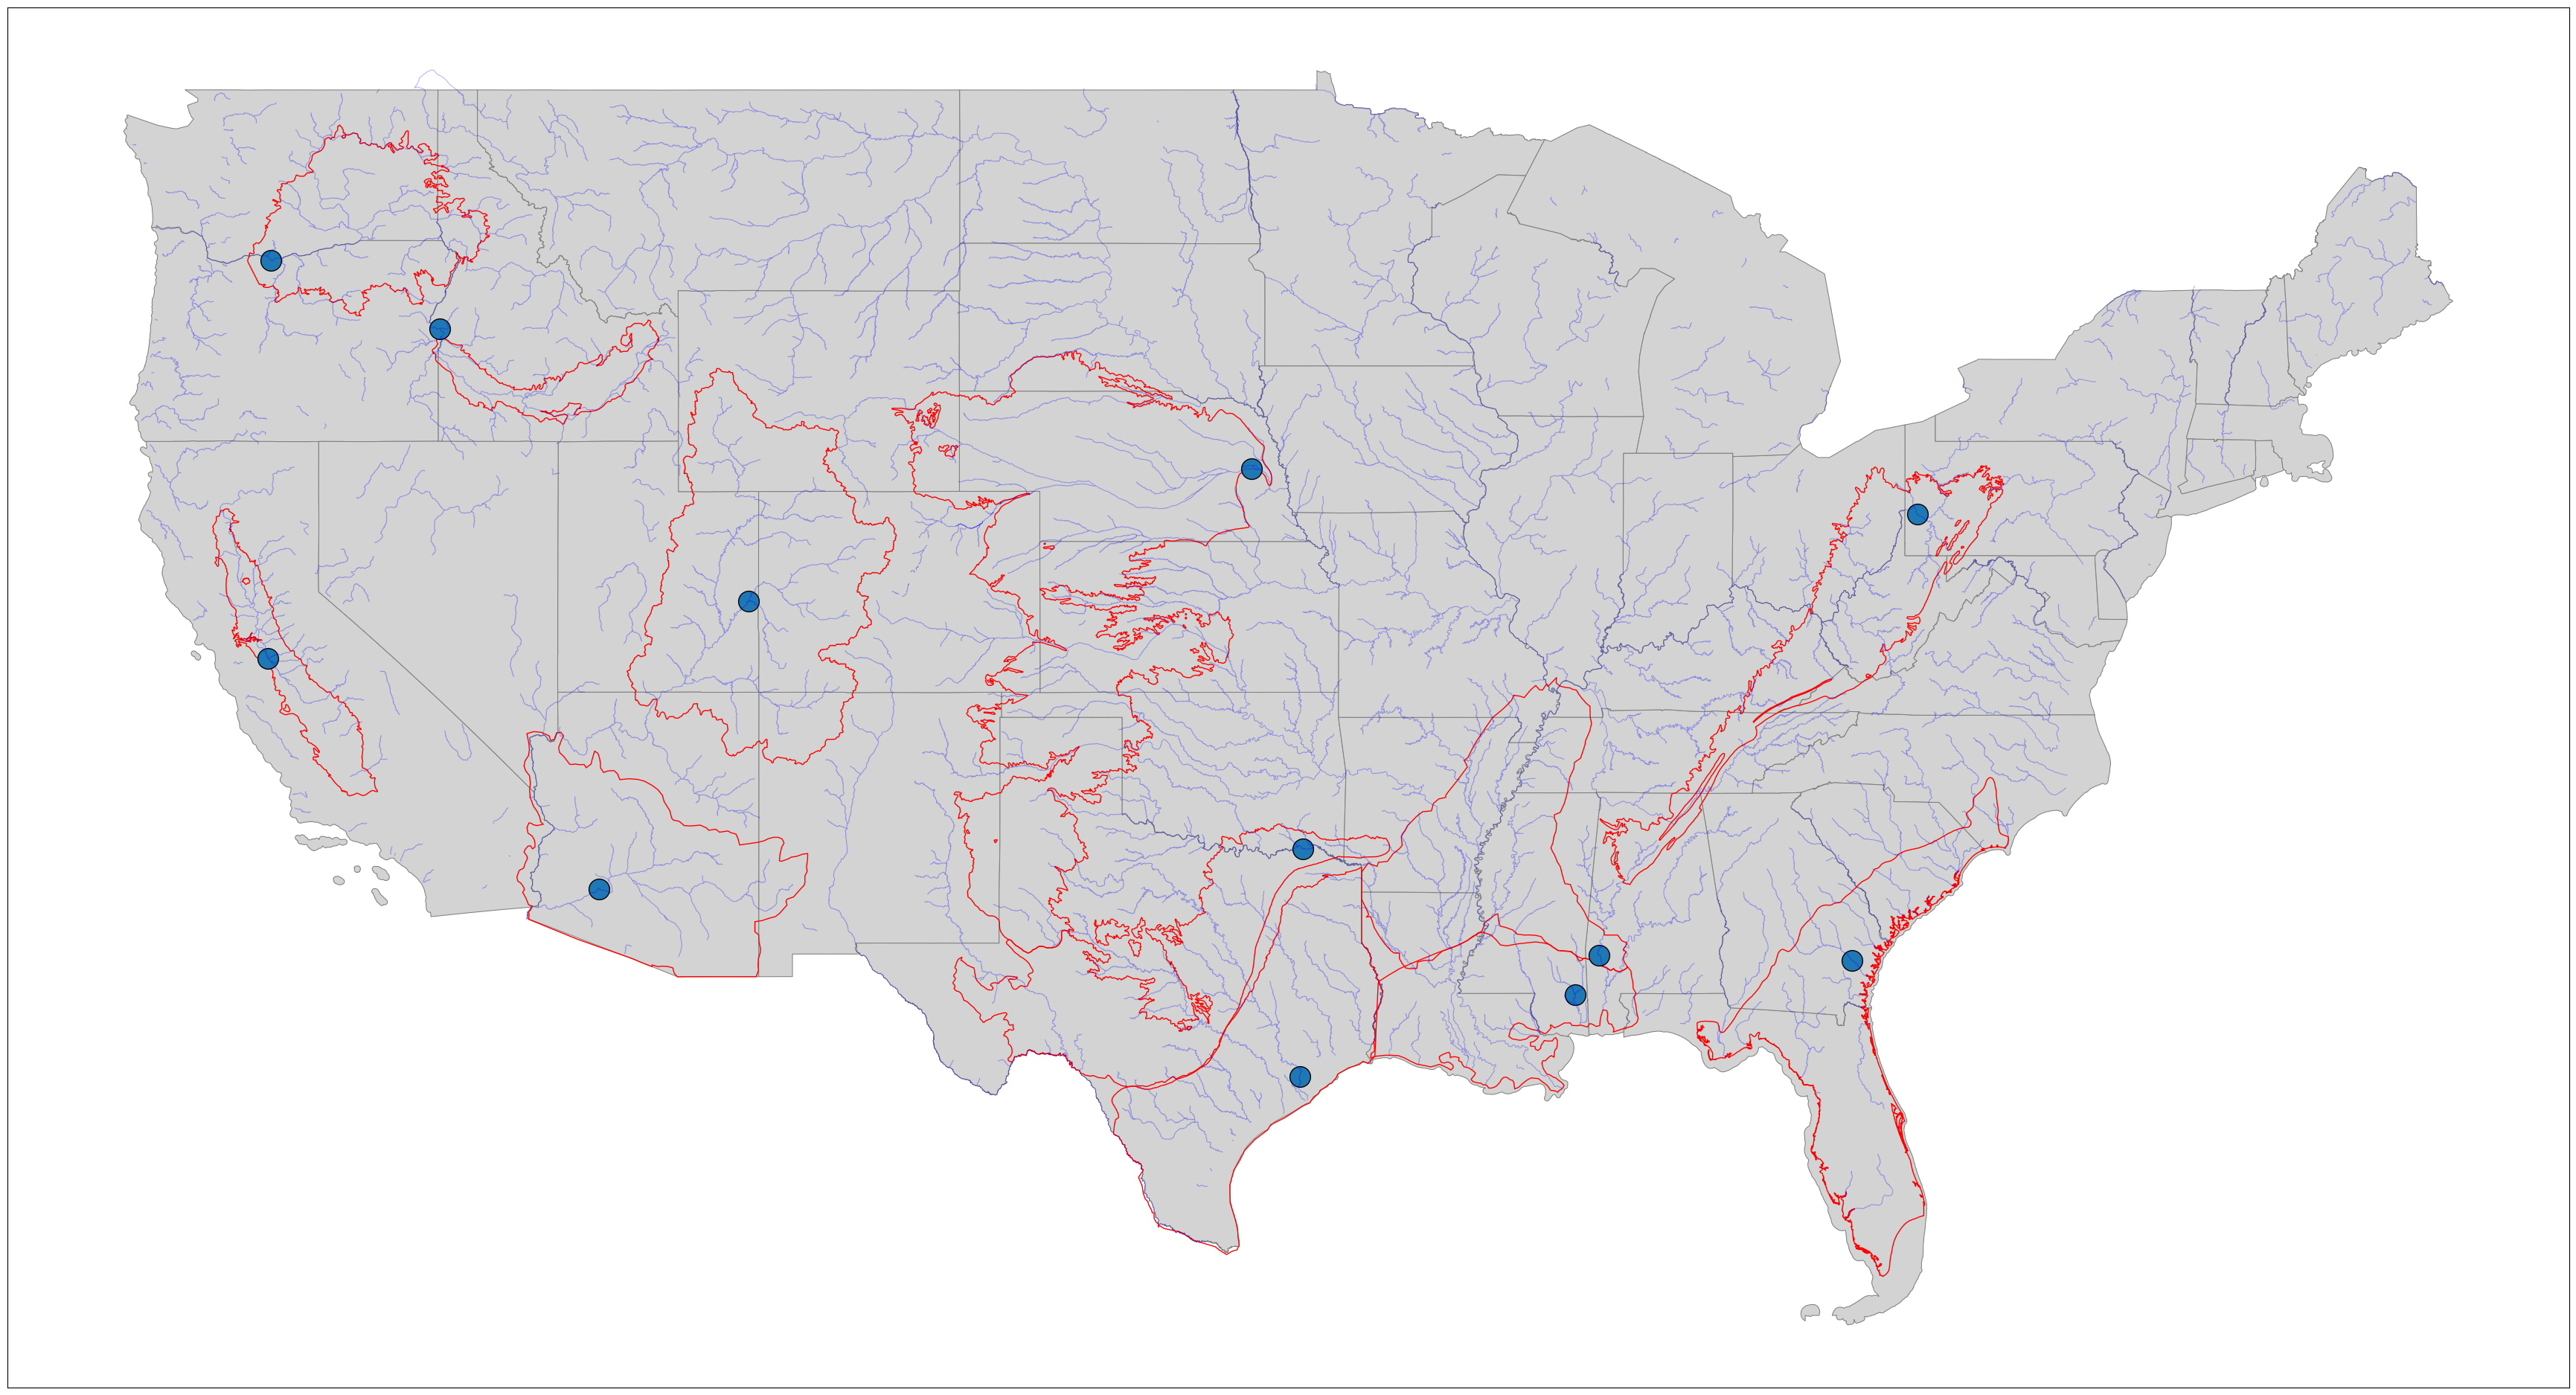

In [13]:
fig, ax = plt.subplots(figsize=(35, 35))

fn.plot_stream_network(stream_network, ax)
fn.plot_lower_48(ax, facecolor='lightgray', edgecolor='gray')
aq_shape.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=1.0, alpha=1.0)

plt.scatter(df_outlets['dec_long_va'], df_outlets['dec_lat_va'], edgecolor='black', marker='o', s=400, alpha=1.0)
    
plt.tight_layout()
ax.set_yticks([])
ax.set_xticks([])

plt.show()

## Plot 5: Full Aquifer Plot w/Outlet Gauges

In [78]:
aquifer = cl.arizona_alluvial_aquifer
metric = 'annual_hmf'
date_range = 30
quantile = 90
dataset = f'Prelim_Data/{aquifer.name}/{aquifer.name}_{date_range}_{quantile}.xlsx'

df_outlets = pd.read_excel('Prelim_Data/_Outlet_Gauges/outlet_gauges.xlsx', dtype={'site_no': str, 'aquifer': str})

try:
    df_5 = pd.read_excel(dataset, dtype=fn.DATASET_DTYPES)
    df_5, _ = fn.filter_by_valid(df_5)
    df_5 = df_5.reset_index(drop=True)
except Exception as e:
    print(e)
    df_5 = pd.DataFrame() 

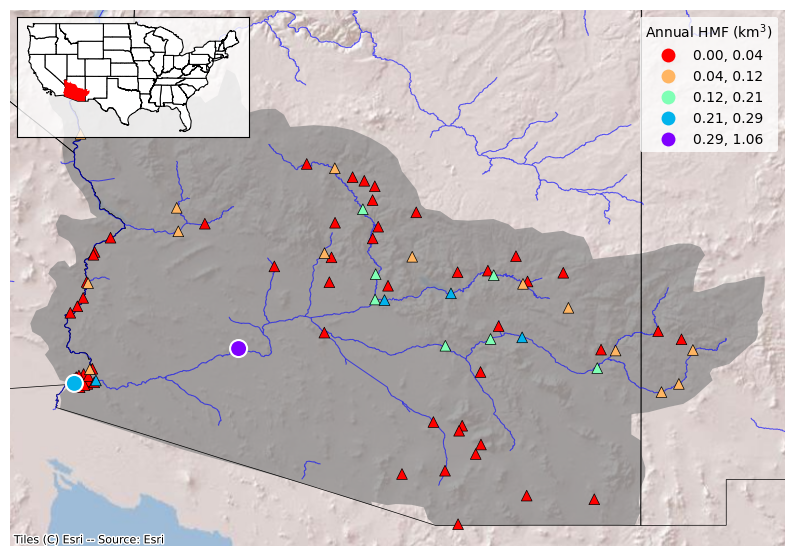

In [79]:
fig, ax = plt.subplots(figsize=(10, 10))

legend_frmt = {
    "title": f"{fn.FLOW_METRIC_UNITS[metric]}",
    "reverse": False,
    #"loc": "lower right",
    "facecolor": "white",
    "alignment": 'center',
    "edgecolor": 'none',
    "framealpha": 0.80
}

# Aquifer shape
aq_shape_5 = aq_shape[aq_shape['aq_name'] == aquifer.name]
aq_shape_5.plot(ax=ax, facecolor='grey', edgecolor='none', linewidth=1.0, alpha=0.65)

# State basemap
fn.plot_lower_48(ax, facecolor='none', edgecolor='black', alpha=1.0, linewidth=0.50)

# Stream network
fn.plot_stream_network(stream_network, ax, alpha=0.60)

gdf_5 = fn.convert_geometry(df_5)
gdf_5 = gdf_5.merge(df_5, how='left', left_index=True, right_index=True)
gdf_5 = gdf_5[gdf_5['within_aq'] == aquifer.name]
gdf_5_filter = gdf_5[gdf_5['site_no'].isin(df_outlets['site_no'])]

classifier = mc.NaturalBreaks(gdf_5[metric])
gdf_5 = gdf_5.sort_values(metric, ascending=True)

# All gauges
cmap='rainbow_r'
gdf_5.plot(ax=ax, column=metric, scheme='user_defined', classification_kwds={'bins': classifier.bins}, cmap=cmap, legend=True, legend_kwds=legend_frmt, 
           alpha=1.0, marker='^', markersize=60, edgecolor='black', linewidth=0.5)

# Outlet gauges
gdf_5_filter.plot(ax=ax, column=metric, scheme='user_defined', classification_kwds={'bins': classifier.bins}, cmap=cmap, marker='o', markersize=150, edgecolor='white', linewidth=1.5)

# Inset map
inset = inset_axes(ax, width='30%', height='30%', loc='upper left')
inset.set_aspect('equal', anchor="NW")
inset.patch.set_alpha(0.80)
fn.plot_lower_48(inset, facecolor='white', edgecolor='black')
aq_shape_5.plot(ax=inset, facecolor='red', edgecolor='none', linewidth=1.0, alpha=1.0)

xmin, xmax, ymin, ymax = fn.set_plot_bounds(aq_shape_5, padding=0.20)
ax.set_facecolor('lightskyblue')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Context basemap
fn.plot_basemap(ax, source=cx.providers.Esri.WorldShadedRelief)

ax.set_yticks([])
ax.set_xticks([])
inset.set_yticks([])
inset.set_xticks([])
plt.show()

## Plot 6: Outlet Gauge Metric Plots

In [91]:
aquifers = cl.ALL_AQUIFERS
date_range = 30
quantile = 90
metric = 'inter_annual%'

dataset = f'Prelim_Data/_Outlet_Gauges/Outlet_Metrics_{date_range}_{quantile}.xlsx'

try:
    df_6 = pd.read_excel(dataset, dtype=fn.DATASET_DTYPES)
except Exception as e:
    print(e)
    df_6 = pd.DataFrame()


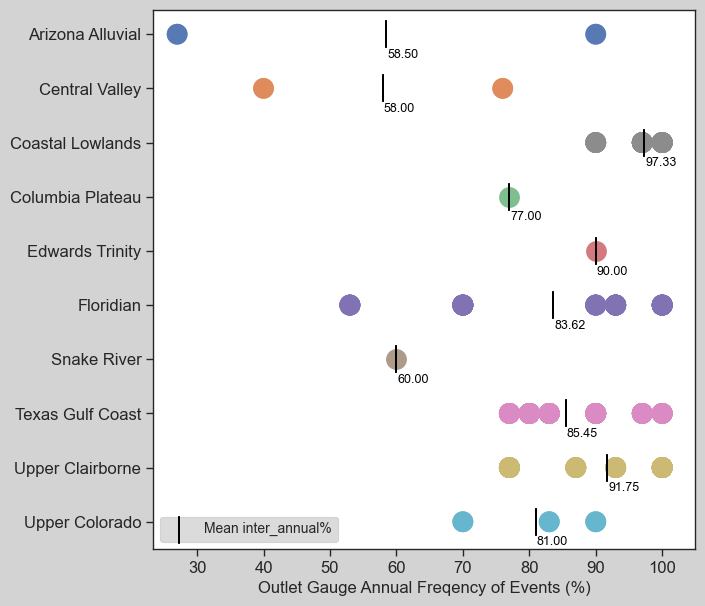

In [93]:
# Data init

sns.set_theme(context='paper', style='ticks', palette='deep')
fig, ax = plt.subplots(figsize=(7, 7), facecolor='lightgrey')
sns.stripplot(data=df_6, x=metric, y='aquifer', hue='aquifer', jitter=False, size=15, alpha=0.75, order=sorted(df_6['aquifer']), zorder=1, legend=False)

if metric == 'annual_hmf':
    hmf_sums = df_6.groupby('aquifer')[metric].sum().reset_index()
    hmf_sums = hmf_sums.sort_values('aquifer', ascending=True)
    sns.scatterplot(data=hmf_sums, x=metric, y='aquifer', marker='_', linewidth=20, color='black', s=1, zorder=2, legend=True, label=f'Total {metric}')
    for i, point in hmf_sums.iterrows():
        plt.text(point[metric] + 0.10, i + 0.38, f'{point[metric]:.2f}', fontsize=9, color='black', ha='left', va='center')
        
else:
    hmf_sums = df_6.groupby('aquifer')[metric].mean().reset_index()
    hmf_sums = hmf_sums.sort_values('aquifer', ascending=True)
    sns.scatterplot(data=hmf_sums, x=metric, y='aquifer', marker='_', linewidth=20, color='black', s=1, zorder=2, legend=True, label=f'Mean {metric}')
    for i, point in hmf_sums.iterrows():
        plt.text(point[metric] + 0.10, i + 0.38, f'{point[metric]:.2f}', fontsize=9, color='black', ha='left', va='center')
    

yticks = [tick.get_text().replace('_', ' ') for tick in ax.get_yticklabels()]
ytick_pos = ax.get_yticks()
plt.xticks(fontsize=12)
plt.yticks(ytick_pos, yticks, fontsize=12)
plt.xlabel(f'Outlet Gauge {fn.FLOW_METRIC_UNITS[metric]}', fontsize=12)
plt.ylabel(None)
plt.xlim(right=df_6[metric].max() + 5)
plt.ylim(bottom=9.5)
plt.legend(loc='lower left', fontsize=10, facecolor='lightgrey')
#sns.despine()
plt.show()

## Plot 7: Monthly HMF of Outlet Gauges as a Percentage of Total HMF

In [17]:
date_range = 30
quantile = 90
metric = 'inter_annual%'

dataset = f'Prelim_Data/_Outlet_Gauges/Outlet_Metrics_{date_range}_{quantile}.xlsx'

try:
    df_7 = pd.read_excel(dataset, dtype=fn.DATASET_DTYPES)
except Exception as e:
    print(e)
    df_7 = pd.DataFrame()

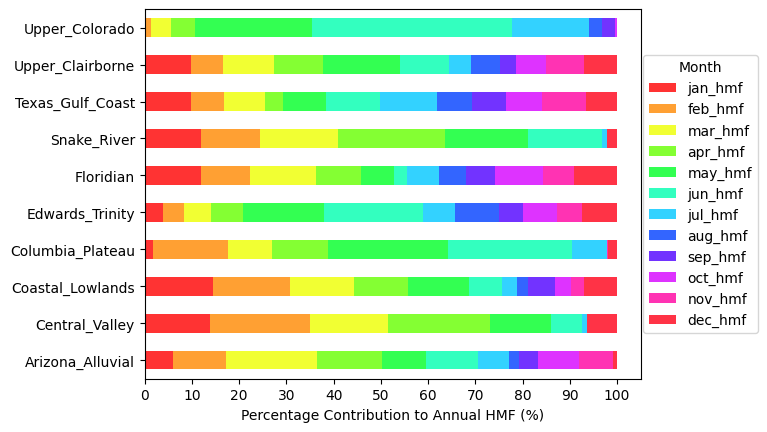

In [39]:
# Data init
df_7 = df_7.sort_values(by='aquifer', ascending=True)
monthly_sums = df_7.groupby('aquifer')[['jan_hmf', 'feb_hmf', 'mar_hmf', 'apr_hmf', 'may_hmf', 'jun_hmf',
                                        'jul_hmf', 'aug_hmf', 'sep_hmf', 'oct_hmf', 'nov_hmf', 'dec_hmf']].mean()

totals = monthly_sums.sum(axis=1)
percentages = monthly_sums.div(totals, axis=0) * 100
percentages = percentages.round(2).reset_index()

ax = percentages.plot(x='aquifer', kind='barh', stacked=True, colormap='hsv', alpha=0.80, mark_right=True, legend=True)
ax.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), title='Month', fontsize=10)
ax.set_xlabel('Percentage Contribution to Annual HMF (%)')
ax.set_ylabel(None)
ax.set_xticks(np.arange(0, 101, 10))

plt.show()

## Plot 8: Validty Visualizations 
Additional visualizations on gauge validity using updated national datasets w/o the 50-year range exclusion check 

In [63]:
aquifers = cl.ALL_AQUIFERS
quantile = 90

dataset_30 = f'Prelim_Data/_National_Metrics/National_Metrics_30_{quantile}.xlsx'
dataset_50 = f'Prelim_Data/_National_Metrics/National_Metrics_50_{quantile}.xlsx'

try:
    df_30 = pd.read_excel(dataset_30, dtype=fn.DATASET_DTYPES)
    df_50 = pd.read_excel(dataset_50, dtype=fn.DATASET_DTYPES)
except Exception as e:
    print(e)
    df_30 = pd.DataFrame()
    df_50 = pd.DataFrame()

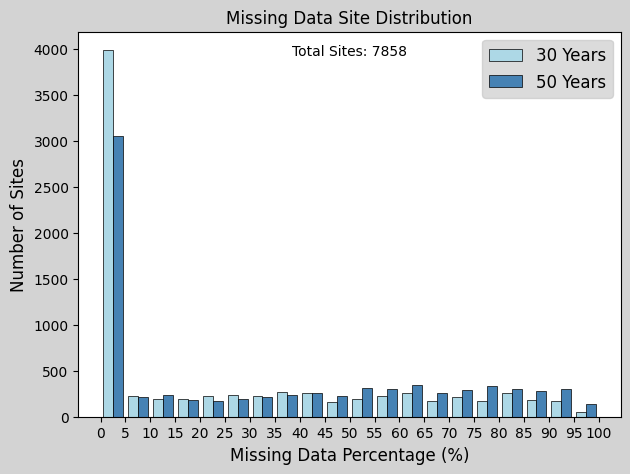

In [57]:
count_30 = df_30.groupby('missing_data%')['site_no'].count().reset_index()
count_50 = df_50.groupby('missing_data%')['site_no'].count().reset_index()

fig, ax = plt.subplots(figsize=(7, 5), facecolor='lightgrey')
plt.title("Missing Data Site Distribution", fontsize=12)
plt.hist((df_30['missing_data%'], df_50['missing_data%']) , bins=20, alpha=1.0, color=['lightblue', 'steelblue'], 
         edgecolor='black', linewidth=0.5, label=['30 Years', '50 Years'])

plt.text(0.5, 0.95, f"Total Sites: {len(df_30)}", fontsize=10, color='black', ha='center', va='center', transform=ax.transAxes)

plt.legend(loc='upper right', fontsize=12, facecolor='lightgrey')
plt.xlabel('Missing Data Percentage (%)', fontsize=12)
plt.ylabel('Number of Sites', fontsize=12)
plt.xticks(np.arange(0, 101, step=5))
plt.show()

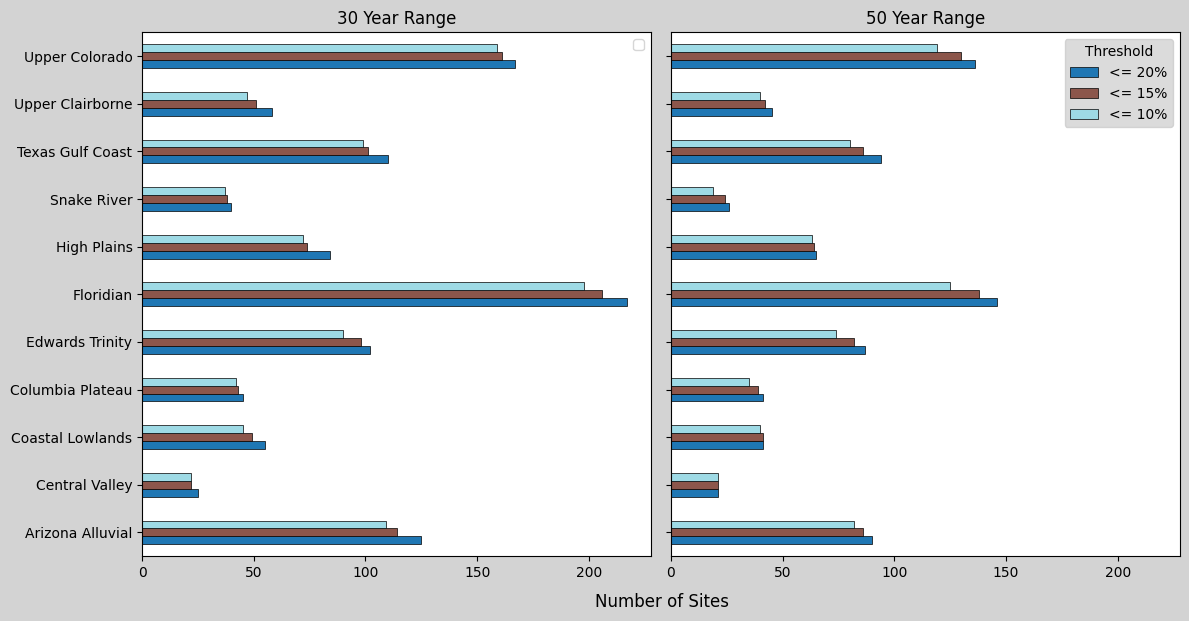

In [113]:
# Data init
aq_dict_30 = {}
for aquifer in cl.ALL_AQUIFERS:
    temp = df_30[df_30['within_aq'] == aquifer.name]
    twenty = len(temp[temp['missing_data%'] <= 20.0])
    fifteen = len(temp[temp['missing_data%'] <= 15.0])
    ten = len(temp[temp['missing_data%'] <= 10.0])
    aq_dict_30[aquifer.name] = (twenty, fifteen, ten)
    
aq_dict_50 = {}
for aquifer in cl.ALL_AQUIFERS:
    temp = df_50[df_50['within_aq'] == aquifer.name]
    twenty = len(temp[temp['missing_data%'] <= 20.0])
    fifteen = len(temp[temp['missing_data%'] <= 15.0])
    ten = len(temp[temp['missing_data%'] <= 10.0])
    aq_dict_50[aquifer.name] = (twenty, fifteen, ten)      

fig, ax = plt.subplots(1, 2, figsize=(12, 6), facecolor='lightgrey', sharey=True, sharex=True, layout='tight')

aq_df_30 = pd.DataFrame(aq_dict_30).T
aq_df_50 = pd.DataFrame(aq_dict_50).T

aq_df_30.plot(ax=ax[0], kind='barh', cmap='tab20', edgecolor='black', linewidth=0.5)
aq_df_50.plot(ax=ax[1], kind='barh', cmap='tab20', edgecolor='black', linewidth=0.5)

fig.text(0.5, -0.02, 'Number of Sites', fontsize=12)
ax[0].set_title('30 Year Range')
ax[1].set_title('50 Year Range')

ax[0].legend([])
ax[1].legend(['<= 20%', '<= 15%', '<= 10%'], title='Threshold', fontsize=10, loc='upper right', facecolor='lightgrey')

yticks = [tick.get_text().replace('_', ' ') for tick in ax[0].get_yticklabels()]
ytick_pos = ax[0].get_yticks()
ax[0].set_yticklabels(yticks, fontsize=10)

plt.show()


## Plot 9: Inter-Annual Frequency of HMF versus--

In [53]:
aquifer = cl.upper_clairborne_aquifer
date_range = 30
quantile = 90

compare_to = "annual_duration"

# Analyze full nation instead of individual aquifers
nationwide = True

if nationwide:
    try:
        dataset = f'Prelim_Data/_National_Metrics/National_Metrics_{date_range}_{quantile}.xlsx'
        df_9 = pd.read_excel(dataset, dtype=fn.DATASET_DTYPES)
        df_9, _ = fn.filter_by_valid(df_9)
        df_9 = df_9.reset_index(drop=True)
    except Exception as e:
        print(e)
        df_9 = pd.DataFrame()        
else:
    try:
        dataset = f'Prelim_Data/{aquifer.name}/{aquifer.name}_{date_range}_{quantile}.xlsx'
        df_9 = pd.read_excel(dataset, dtype=fn.DATASET_DTYPES)
        df_9, _ = fn.filter_by_valid(df_9)
        df_9 = df_9.reset_index(drop=True)
    except Exception as e:
        print(e)
        df_9 = pd.DataFrame()
        
df_9 = df_9.sort_values(by='annual_hmf', ascending=True)

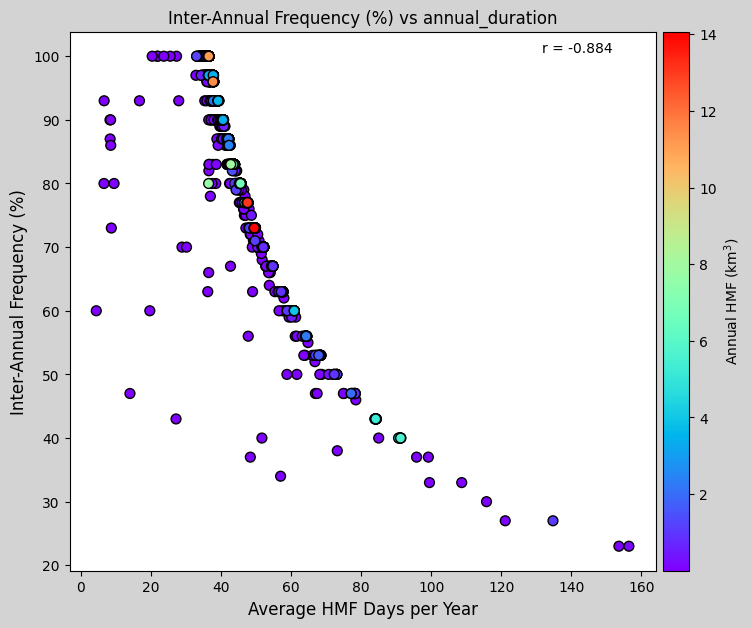

In [73]:
fig, ax = plt.subplots(figsize=(9, 7), facecolor='lightgrey')
plt.title(f"Inter-Annual Frequency (%) vs {compare_to}", fontsize=12)

#classifier = mc.Quantiles(df_9['annual_hmf'])
#cmap = plt.get_cmap('winter')
#colors = [cmap(classifier(i)) for i in df_9['annual_hmf']]

plot = plt.scatter(df_9[compare_to], df_9['inter_annual%'], c=df_9['annual_hmf'], cmap='rainbow', edgecolor='black', s=50, alpha=1.0)
pearson_corr = df_9['inter_annual%'].corr(df_9[compare_to], method='pearson')
fig.text(0.65, 0.85, f"r = {pearson_corr:.3f}", fontsize=10)

cb = plt.colorbar(plot, label='Annual HMF ($\mathregular{km^3}$)', pad=0.01)

plt.ylabel('Inter-Annual Frequency (%)', fontsize=12)
plt.xlabel(f'{fn.FLOW_METRIC_UNITS[compare_to]}', fontsize=12)

plt.show()